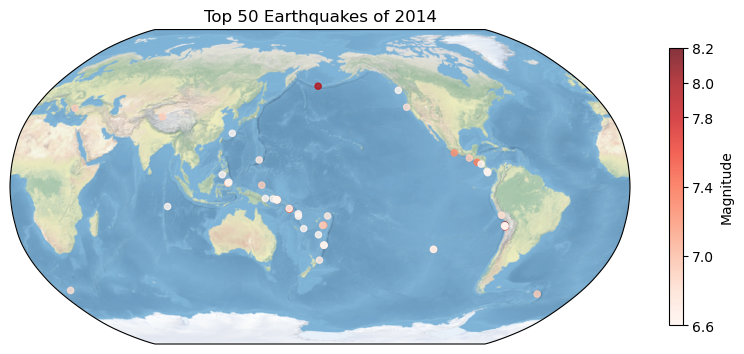

In [3]:
#1
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def main():
    # Load earthquake data
    df = pd.read_csv("usgs_earthquakes.csv")
    # Filter to top 50 (sort by magnitude descending, take first 50)
    df_top50 = df.sort_values("mag", ascending=False).head(50)

    # Set up figure and Robinson projection (central longitude 180)
    fig = plt.figure(figsize=(10, 6))
    proj = ccrs.Robinson(central_longitude=180)
    ax = fig.add_subplot(111, projection=proj)

    # Style the map
    ax.set_global()
    ax.stock_img()

    # Define magnitude colormap (matches the example's red gradient)
    norm = Normalize(vmin=6.6, vmax=8.2)  # Match colorbar range in the example
    cmap = cm.Reds  # Red gradient for magnitude

    # Plot earthquakes: scatter points with magnitude-based color
    scatter = ax.scatter(
        df_top50["longitude"],
        df_top50["latitude"],
        c=df_top50["mag"],
        cmap=cmap,
        norm=norm,
        s=20,  # Adjust size as needed
        alpha=0.8,
        transform=ccrs.PlateCarree()  # Earthquake coordinates are in PlateCarree
    )

    # Add colorbar (matches the example's magnitude range)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, label="Magnitude")
    cbar.set_ticks([6.6, 7.0, 7.4, 7.8, 8.0, 8.2])  # Match example's colorbar ticks

    plt.title("Top 50 Earthquakes of 2014")
    plt.show()

if __name__ == '__main__':
    main()

E:\ancon\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


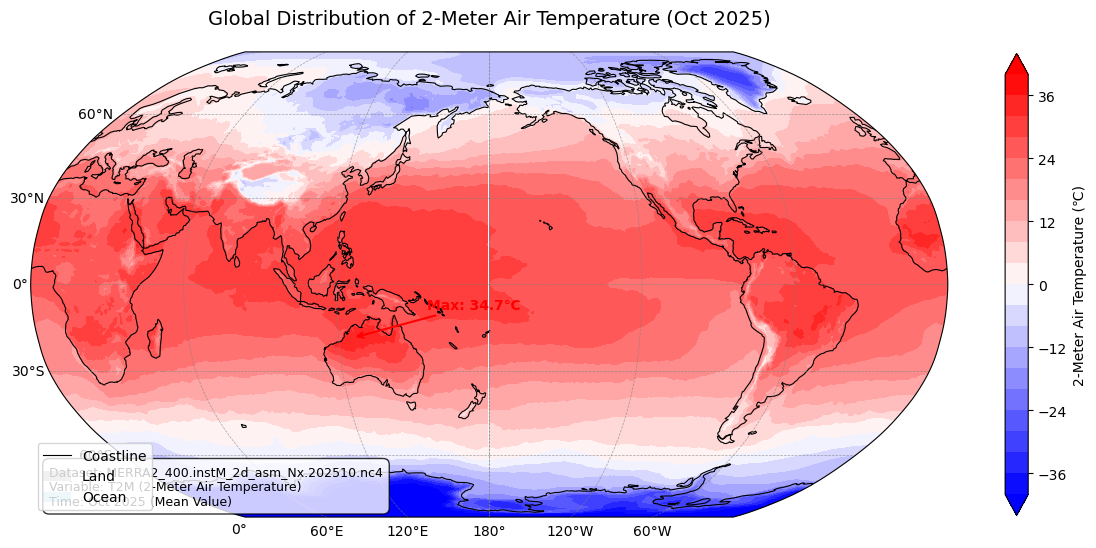

E:\ancon\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


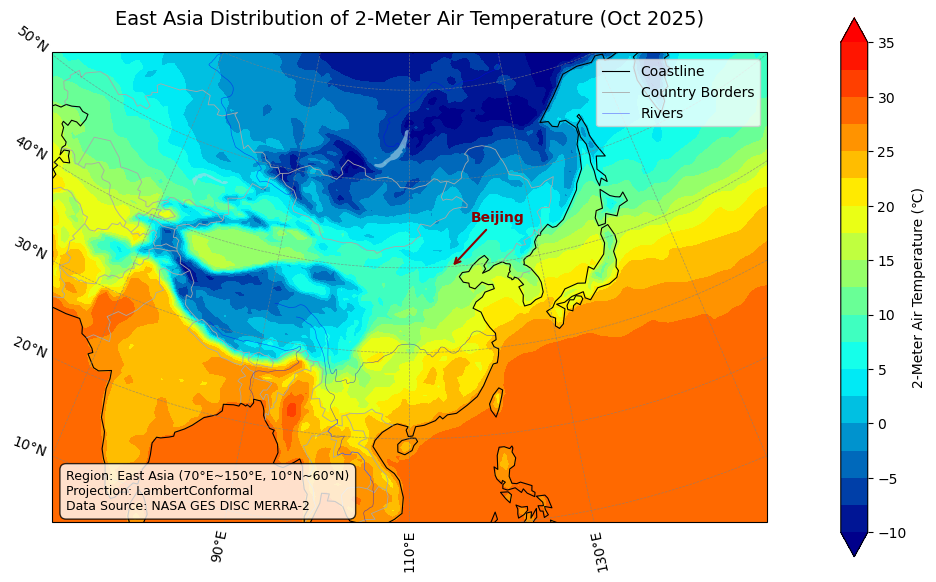

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

file_path = "MERRA2_400.instM_2d_asm_Nx.202510.nc4"
ds = xr.open_dataset(file_path)
t2m = ds["T2M"] - 273.15
if t2m.ndim == 3:
    t2m_mean = t2m.mean(dim="time").squeeze()
else:
    t2m_mean = t2m.squeeze()
lon = ds["lon"].values
lat = ds["lat"].values

def plot_global_map():
    proj_global = ccrs.Robinson(central_longitude=180)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": proj_global})
    contourf = ax.contourf(
        lon, lat, t2m_mean,
        levels=np.linspace(-40, 40, 21),
        cmap=LinearSegmentedColormap.from_list("temp", ["blue", "white", "red"]),
        transform=ccrs.PlateCarree(),
        extend="both"
    )
    coast = ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color="black")
    land = ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
    ocean = ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.2)
    
    ax.set_global()
    ax.set_title("Global Distribution of 2-Meter Air Temperature (Oct 2025)", fontsize=14, pad=20)
    ax.set_xlabel("Longitude (°E)", fontsize=12, labelpad=15)
    ax.set_ylabel("Latitude (°N)", fontsize=12, labelpad=20)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle="--", linewidth=0.5, color="gray", alpha=0.7,
                      xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                      draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    
    cbar = plt.colorbar(contourf, ax=ax, shrink=0.6, pad=0.05, label="2-Meter Air Temperature (℃)")
    cbar.ax.tick_params(labelsize=10)
    
    legend_elements = [plt.Line2D([0], [0], color=coast.get_edgecolor(), lw=coast.get_linewidth(), label="Coastline"),
                       plt.Rectangle((0,0),1,1, facecolor=land.get_facecolor()[0], alpha=land.get_alpha(), label="Land"),
                       plt.Rectangle((0,0),1,1, facecolor=ocean.get_facecolor()[0], alpha=ocean.get_alpha(), label="Ocean")]
    ax.legend(handles=legend_elements, loc="lower left", fontsize=10, frameon=True)
    
    max_temp_idx = np.unravel_index(np.argmax(t2m_mean.values), t2m_mean.shape)
    max_lon = lon[max_temp_idx[1]]
    max_lat = lat[max_temp_idx[0]]
    ax.annotate(f"Max: {t2m_mean.max().values:.1f}℃",
                xy=(max_lon, max_lat), xytext=(max_lon+30, max_lat+10),
                xycoords=ccrs.PlateCarree(), textcoords=ccrs.PlateCarree(),
                arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
                fontsize=10, color="red", fontweight="bold")
    
    text_box = """Dataset: MERRA2_400.instM_2d_asm_Nx.202510.nc4
Variable: T2M (2-Meter Air Temperature)
Time: Oct 2025 (Mean Value)"""
    ax.text(0.02, 0.02, text_box, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
            fontsize=9, verticalalignment="bottom")
    
    plt.tight_layout()
    plt.savefig("global_t2m_map.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_regional_map():
    proj_regional = ccrs.LambertConformal(central_longitude=110, central_latitude=35, standard_parallels=(25, 45))
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": proj_regional})
    ax.set_extent([70, 150, 10, 60], crs=ccrs.PlateCarree())
    
    contourf = ax.contourf(
        lon, lat, t2m_mean,
        levels=np.linspace(-10, 35, 19),
        cmap=LinearSegmentedColormap.from_list("temp_reg", ["darkblue", "cyan", "yellow", "red"]),
        transform=ccrs.PlateCarree(),
        extend="both"
    )
    
    coast = ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color="black")
    borders = ax.add_feature(cfeature.BORDERS, linewidth=0.6, color="darkgray")
    rivers = ax.add_feature(cfeature.RIVERS, linewidth=0.4, color="blue", alpha=0.6)
    lakes = ax.add_feature(cfeature.LAKES, facecolor="lightblue", alpha=0.6)
    
    ax.set_title("East Asia Distribution of 2-Meter Air Temperature (Oct 2025)", fontsize=14, pad=20)
    ax.set_xlabel("Longitude (°E)", fontsize=12, labelpad=15)
    ax.set_ylabel("Latitude (°N)", fontsize=12, labelpad=20)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle="--", linewidth=0.5, color="gray", alpha=0.7,
                      xlocs=np.arange(70, 151, 20), ylocs=np.arange(10, 61, 10),
                      draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    
    cbar = plt.colorbar(contourf, ax=ax, shrink=0.7, pad=0.08, label="2-Meter Air Temperature (℃)")
    cbar.ax.tick_params(labelsize=10)
    
    legend_elements = [plt.Line2D([0], [0], color=coast.get_edgecolor(), lw=coast.get_linewidth(), label="Coastline"),
                       plt.Line2D([0], [0], color=borders.get_edgecolor(), lw=borders.get_linewidth(), label="Country Borders"),
                       plt.Line2D([0], [0], color=rivers.get_edgecolor(), lw=rivers.get_linewidth(), label="Rivers")]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=10, frameon=True)
    
    ax.annotate("Beijing", xy=(116.4, 39.9), xytext=(120, 45),
                xycoords=ccrs.PlateCarree(), textcoords=ccrs.PlateCarree(),
                arrowprops=dict(arrowstyle="->", color="darkred", lw=1.5),
                fontsize=10, color="darkred", fontweight="bold")
    
    text_box = """Region: East Asia (70°E~150°E, 10°N~60°N)
Projection: LambertConformal
Data Source: NASA GES DISC MERRA-2"""
    ax.text(0.02, 0.02, text_box, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
            fontsize=9, verticalalignment="bottom")
    
    plt.tight_layout()
    plt.savefig("east_asia_t2m_map.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_global_map()
plot_regional_map()